In [1]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

In [2]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
4 categories
vectorize training done in 0.262s at 15.212MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.163s at 17.590MB/s
n_samples: 1353, n_features: 7831


In [5]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

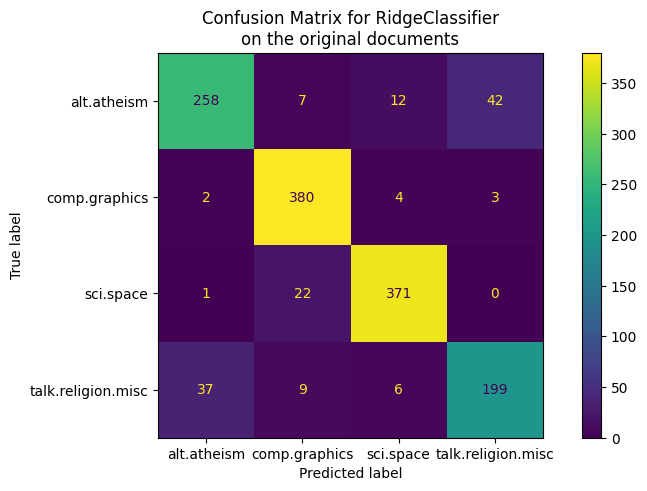

In [7]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)